In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet
import scipy.stats as stats

### Montar Dataframe

In [3]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [4]:
# Query para consulta dos dados agrupados por taxa média por quadrimestre
consulta_sql = """
select
	tx.quadrimestre,
	avg(tx.taxa_yll) as taxa_media_yll
from (
	with yll_quadrimestral as (
		select
			case
				when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
				when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
				when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
				end as quadrimestre,
			m.nm_municipio,
			p.populacao,
			sum(y.yll) as soma_yll
		from `ml-na-saude.yll_por_obito.yll` y
		join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
		join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
		where p.porte = 'Médio Porte'
		group by 1,2,3
	)
	select
		quadrimestre,
		nm_municipio,
		soma_yll,
		populacao,
		soma_yll / populacao * 1000 as taxa_yll
	from yll_quadrimestral
	group by 1,2,3,4
) tx
group by 1
order by 1
"""

In [5]:
# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [6]:
# Copiar dataframe para manipular dados
time_series = df.copy()

In [7]:
# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

In [ ]:
# Filtrar dados até final de 2019
time_series = time_series[time_series['quadrimestre'] <= '2019-12-31']

In [9]:
time_series

,quadrimestre,taxa_media_yll
0,2010-04-30,6.427726
1,2010-08-31,6.767661
2,2010-12-31,6.111099
3,2011-04-30,6.550037
4,2011-08-31,6.878076
5,2011-12-31,5.804813
6,2012-04-30,6.280719
7,2012-08-31,6.739170
8,2012-12-31,6.049970
9,2013-04-30,6.253954


### Modelo Prophet

In [10]:
# Preparar os dados no formato do Prophet
df_prophet = time_series.rename(columns={'quadrimestre': 'ds', 'taxa_media_yll': 'y'})

In [11]:
# Dividir em treino e teste
train = df_prophet[df_prophet['ds'] <= '2016-12-31']
test = df_prophet[df_prophet['ds'] > '2016-12-31']

In [12]:
# Criar e treinar modelo para intervalo de 95%
model_95 = Prophet(
    changepoint_prior_scale=0.001,
    seasonality_prior_scale=0.1,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    interval_width=0.95,
    n_changepoints=5
)
model_95.fit(train)

# Criar e treinar modelo para intervalo de 80%
model_80 = Prophet(
    changepoint_prior_scale=0.001,
    seasonality_prior_scale=0.1,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    interval_width=0.80,
    n_changepoints=5
)
model_80.fit(train)

21:29:06 - cmdstanpy - INFO - Chain [1] start processing
21:29:07 - cmdstanpy - INFO - Chain [1] done processing
21:29:07 - cmdstanpy - INFO - Chain [1] start processing
21:29:07 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Criar dataframe para previsão
future = model_95.make_future_dataframe(periods=9, freq='4M')
forecast_95 = model_95.predict(future)
forecast_80 = model_80.predict(future)

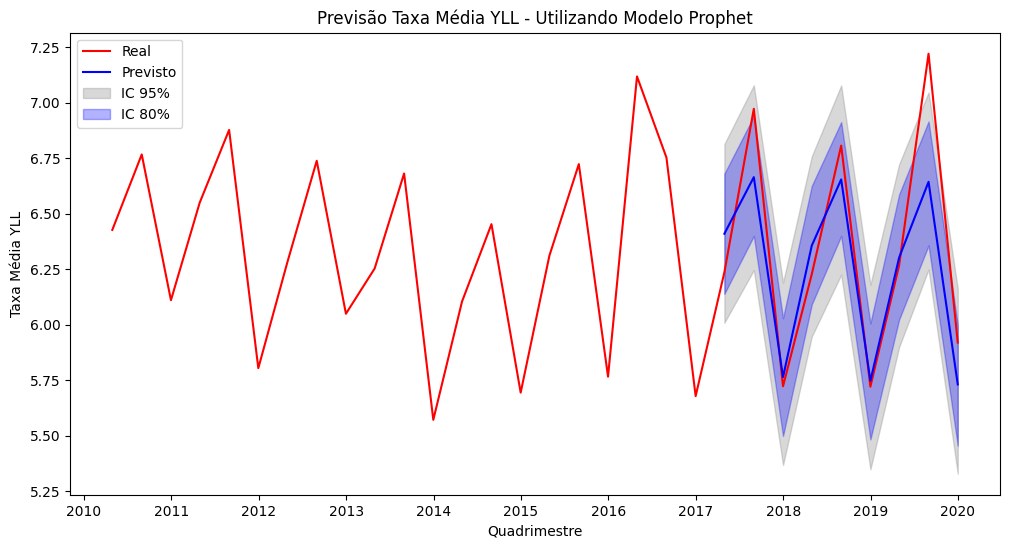

In [ ]:
# Plotar previsão vs real com ambos intervalos de confiança
test_forecast_95 = forecast_95[forecast_95['ds'] > '2016-12-31']
test_forecast_80 = forecast_80[forecast_80['ds'] > '2016-12-31']

plt.figure(figsize=(12, 6))

plt.plot(df_prophet['ds'], df_prophet['y'], color='red', label='Real')
plt.plot(test_forecast_95['ds'], test_forecast_95['yhat'], color='blue', label='Previsto')

# Intervalo de 95%
plt.fill_between(test_forecast_95['ds'],
                 test_forecast_95['yhat_lower'],
                 test_forecast_95['yhat_upper'],
                 color='gray', alpha=0.3, label='IC 95%')

# Intervalo de 80%
plt.fill_between(test_forecast_80['ds'], 
                test_forecast_80['yhat_lower'], 
                test_forecast_80['yhat_upper'],
                color='blue', alpha=0.3, label='IC 80%')

plt.title('Previsão Taxa Média YLL - Utilizando Modelo Prophet')
plt.ylabel('Taxa Média YLL')
plt.xlabel('Quadrimestre')
plt.legend()
plt.show()

In [15]:
# Calcular métricas de erro usando previsões do modelo de 95%
y_true = test['y'].values
y_pred = test_forecast_95['yhat'].values

# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calcular o Erro Percentual Absoluto Médio
mape = mean_absolute_percentage_error(y_true,y_pred)
print(f'MAPE: {mape}')

# Calcular o erro Theil's U2
def theil_u2(actual, predicted):
    numerator = np.sum((actual - predicted) ** 2)
    denominator = np.sum((actual - np.roll(actual, 1)) ** 2) + np.sum((predicted - np.roll(predicted, 1)) ** 2)
    return np.sqrt(numerator / denominator)

tu = theil_u2(y_true, y_pred)
print(f'TU: {tu}')

# Teste de Durbin-Watson
residuals = y_true - y_pred
dw = durbin_watson(residuals)
print(f'Durbin-Watson: {dw}')

MAE: 0.18117635240944413
MSE: 0.059649293972822405
RMSE: 0.24423204943827992
MAPE: 0.027129383286663263
TU: 0.22363126940342737
Durbin-Watson: 1.858402592492267


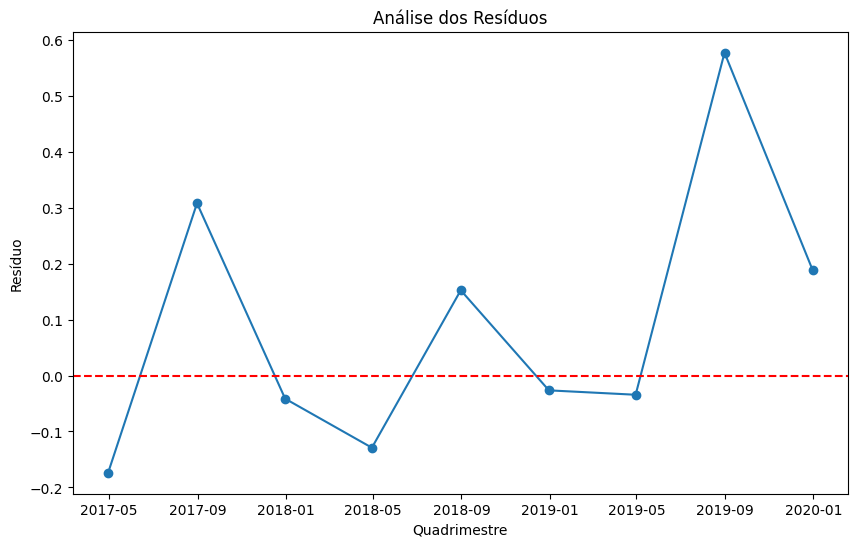

In [16]:
# Análise dos resíduos
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], residuals, 'o-')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Análise dos Resíduos')
plt.xlabel('Quadrimestre')
plt.ylabel('Resíduo')
# plt.grid(True)
plt.show()

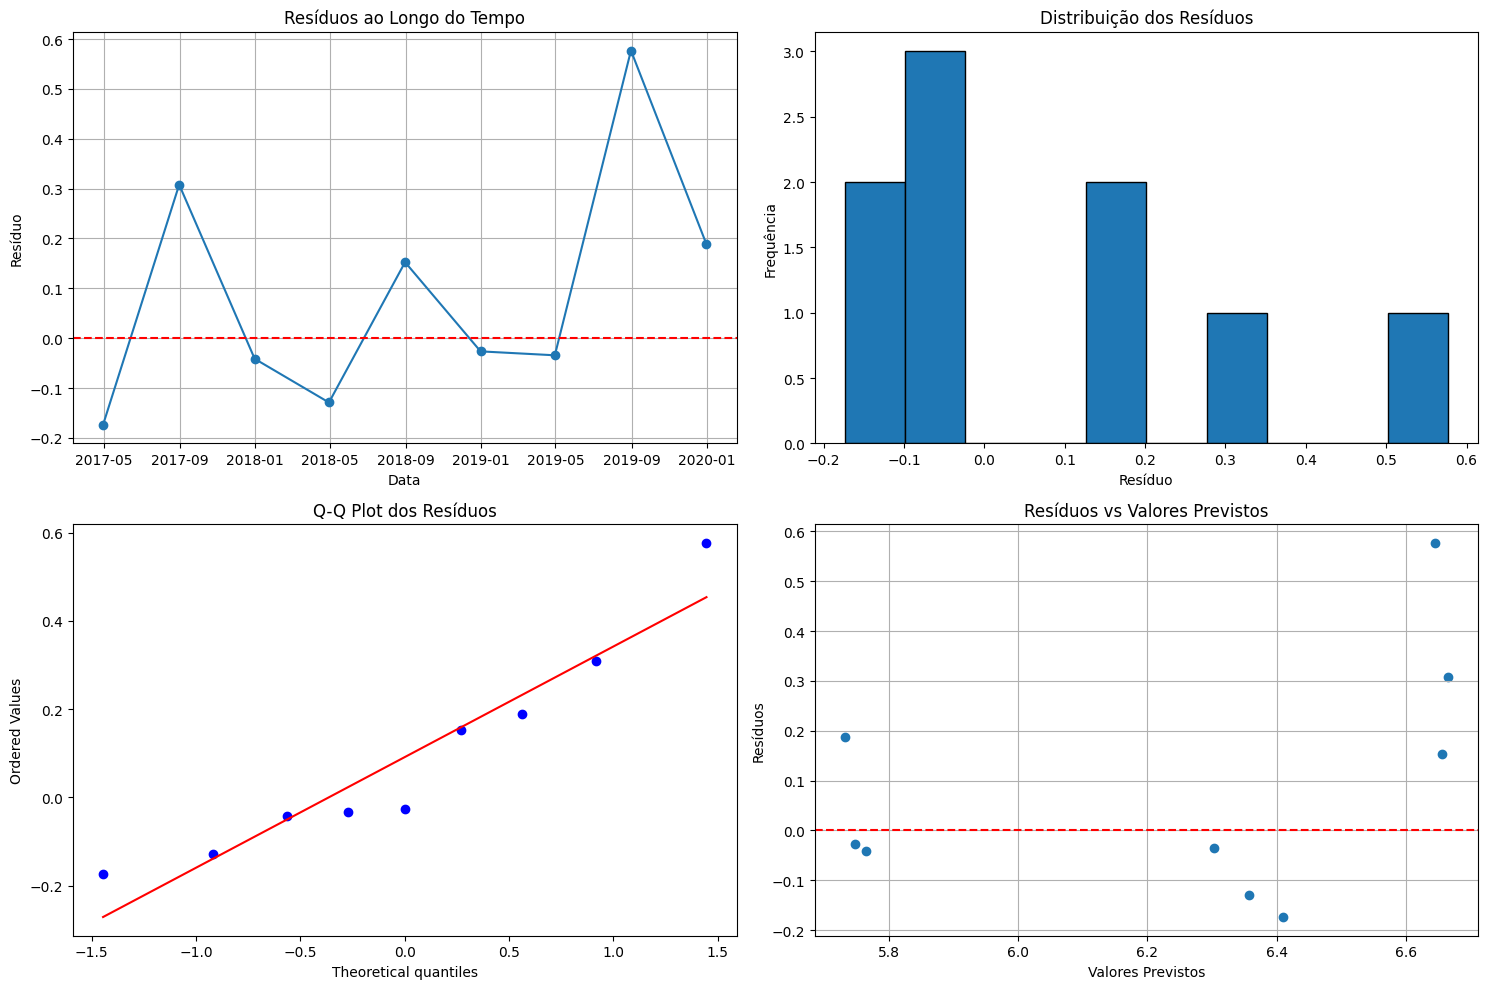


Testes Estatísticos dos Resíduos:
Teste de Normalidade (D'Agostino K²):
p-valor: 0.2648
Resíduos são normais? Sim (α=0.05)

Média dos Resíduos: 0.0912
Desvio Padrão dos Resíduos: 0.2266

Estatística Durbin-Watson: 1.8584
Interpretação do Durbin-Watson:
Não há evidências fortes de autocorrelação


In [ ]:
# Criar figura com subplots para análise completa dos resíduos
fig = plt.figure(figsize=(15, 10))

# 1. Gráfico de Resíduos vs Tempo
plt.subplot(221)
plt.plot(test['ds'], residuals, 'o-')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos ao Longo do Tempo')
plt.ylabel('Resíduo')
plt.xlabel('Data')
plt.grid(True)

# 2. Histograma dos Resíduos
plt.subplot(222)
plt.hist(residuals, bins=10, edgecolor='black')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')

# 3. Q-Q Plot para verificar normalidade
plt.subplot(223)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot dos Resíduos')

# 4. Resíduos vs Valores Previstos
plt.subplot(224)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos vs Valores Previstos')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.grid(True)

plt.tight_layout()
plt.show()

# Testes estatísticos
print("\nTestes Estatísticos dos Resíduos:")

# Teste de normalidade
_, p_value_norm = stats.normaltest(residuals)
print(f"Teste de Normalidade (D'Agostino K²):")
print(f"p-valor: {p_value_norm:.4f}")
print(f"Resíduos são normais? {'Sim' if p_value_norm > 0.05 else 'Não'} (α=0.05)")

# Média dos resíduos
mean_residuals = np.mean(residuals)
print(f"\nMédia dos Resíduos: {mean_residuals:.4f}")

# Desvio padrão dos resíduos
std_residuals = np.std(residuals)
print(f"Desvio Padrão dos Resíduos: {std_residuals:.4f}")

# Teste de autocorrelação (Durbin-Watson já calculado anteriormente)
print(f"\nEstatística Durbin-Watson: {dw:.4f}")
print("Interpretação do Durbin-Watson:")
if dw < 1.5:
    print("Possível autocorrelação positiva")
elif dw > 2.5:
    print("Possível autocorrelação negativa")
else:
    print("Não há evidências fortes de autocorrelação")